In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

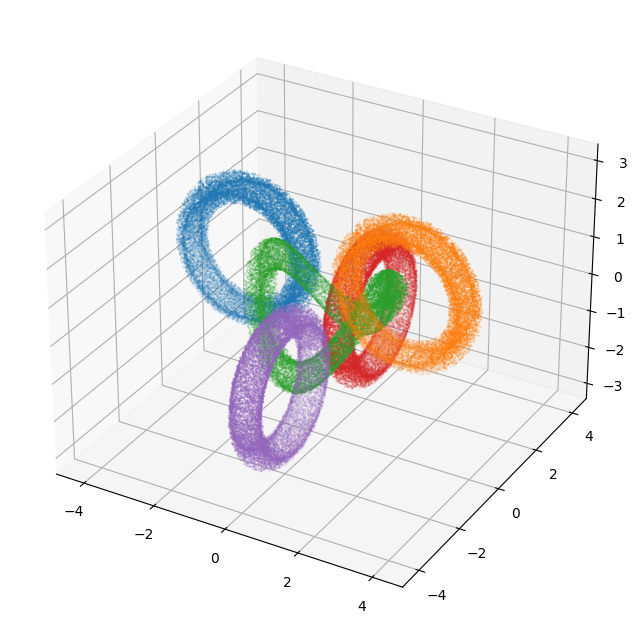

In [2]:
#------------------------------------------------------------------------------
# Read labeled training data from file
labeled_data_pd = pd.read_csv("labeled-dataset-3d-rings.txt", delimiter= ',',dtype=np.float32)

dim_data = 3
# Convert DataFrame to numpy arrays
data_np = labeled_data_pd.iloc[:, :dim_data].values  # extract the first 3 columns
labels_np = labeled_data_pd.iloc[:, dim_data].values.astype(int)  # extract the third column and convert to int

# Convert numpy arrays to torch tensors
data_t = torch.from_numpy(data_np).float()  # shape is (size_data_set, 3)
labels_t = torch.from_numpy(labels_np).long()  # shape is (size_data_set,)

# Determine the number of classes and the x-data range in the data set
N_cl = np.max(labels_np)+1
x_min = data_np.min()
x_max = data_np.max()

#------------------------------------------------------------------------------
# Illustrate the class data
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')

data_colors = ["tab:green","tab:orange","tab:blue","tab:red","tab:purple","tab:cyan","tab:gray"]
for cl in range(N_cl):
    xcl_np = data_np[labels_np == cl]
    ax.scatter(xcl_np[:,0],xcl_np[:,1],xcl_np[:,2], c = data_colors[cl], s=0.03)

plt.show()

In [6]:
#-----------------------------------------------------------------------------
## To to: Find out good parameters
# Number of hidden nodes
N1 = 10  # 
# Number of epochs for training
epochs = 100
# Learning rate for training
learning_rate = 1
# Batch size
batch_size = 100


class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

# Create model
## To do: Define the model with proper input and output dimensions
model = SimpleNN(3 , N1, N_cl)  

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# To do: Define an optimizer for the model parameters, which has a learning rate as defined above by learning_rate.
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Create data loaders
dataset = TensorDataset(data_t, labels_t)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []

# Training loop
pbar = tqdm(range(epochs))
for epoch in pbar:
    for i, data in enumerate(dataloader):
        inputs, labels = data

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Save the current loss

    pbar.set_postfix({"Loss": f'{loss.item():.2e}'})

print(f"Final Loss: {loss.item():.2e}")


  0%|          | 0/100 [00:00<?, ?it/s]

Final Loss: 2.71e-02


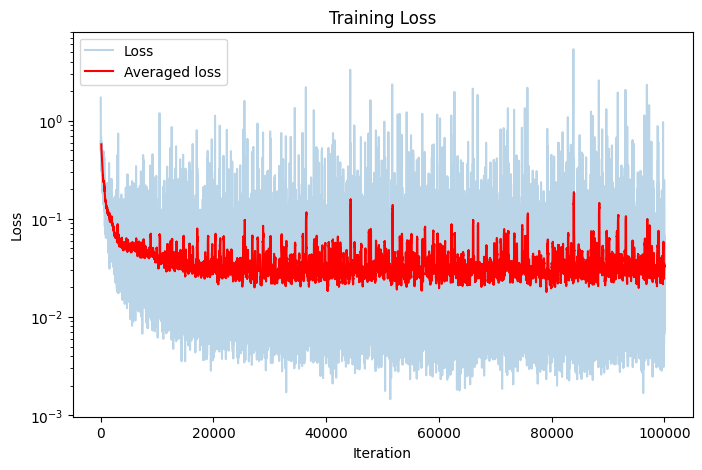

In [10]:
df = pd.DataFrame(losses, columns=['loss'])

# Calculate a rolling average
window_size = 100
df['rolling_loss'] = df['loss'].rolling(window=window_size).mean()

# Plot both the raw loss and the rolling average
plt.figure(figsize=(8, 5))
plt.plot(df['loss'], alpha=0.3)  # Raw loss values in transparent color
plt.plot(df['rolling_loss'], color='r')  # Smoothed loss (rolling average) in bold red color
plt.yscale('log')  
#plt.xscale('log') 
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['Loss', 'Averaged loss'])
plt.show()

In [11]:
#------------------------------------------------------------------------------
# model accuracy test
#------------------------------------------------------------------------------

y_hat_learned = model(data_t)
# To do: Obtain the predicted labels by using the neural network's output y_hat_learned. 
labels_hat_learned = y_hat_learned.detach().numpy().argmax(axis=1)

# To do: Calculate the accuracy of classification by using the dataset data_t and the predicted label labels_hat_learned.

#------------------------------------------------------------------------------

# Test the accuracy for each class.
for cl in range(N_cl):
    # To do: By using numpy indexing, obtain the predicted label of the data whose true labels are cl. 
    labels_hat_learned_cl = labels_hat_learned[labels_np == cl]

    # To do: By using the predicted label, calculate the accuracy of class cl.  
    accuracy_cl = (labels_hat_learned_cl == cl).sum() / len(labels_hat_learned_cl)

    print(f"Accuracy of class {cl}: {accuracy_cl:.2f}")

Accuracy of class 0: 0.97
Accuracy of class 1: 1.00
Accuracy of class 2: 0.98
Accuracy of class 3: 0.98
Accuracy of class 4: 0.99


In [12]:
torch.save(model, 'model-and-parameters-problem-04.pth')

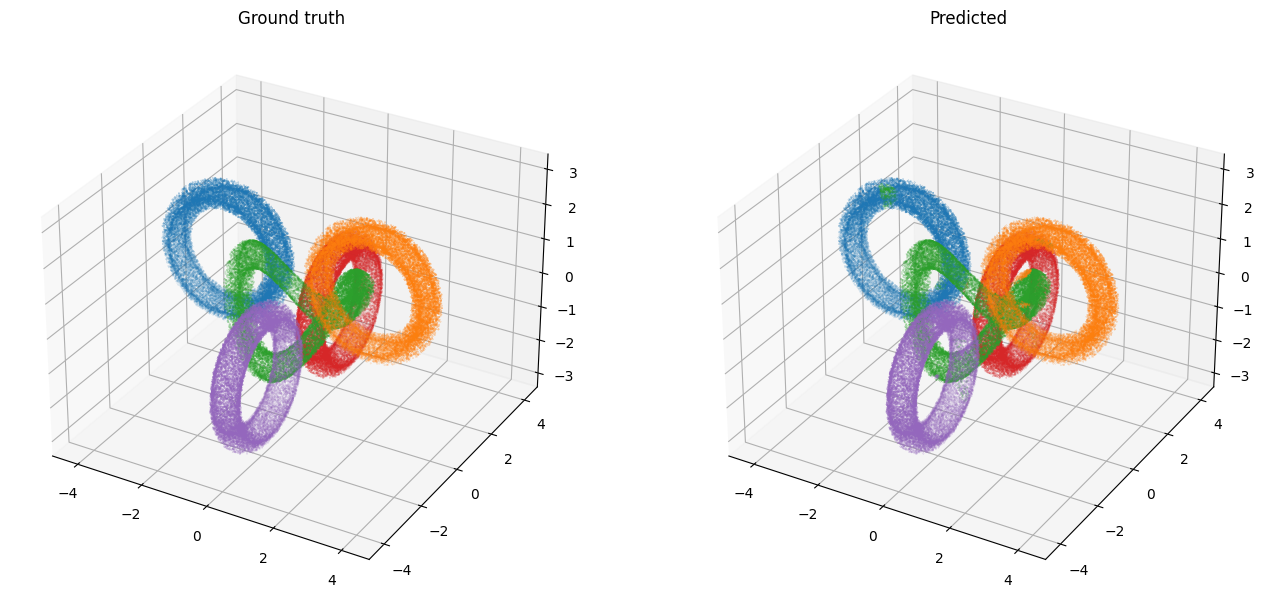

In [20]:

fig = plt.figure(figsize=(16, 8))  
ax_truth = fig.add_subplot(1, 2, 1, projection='3d')
ax_predicted = fig.add_subplot(1, 2, 2, projection='3d')

data_colors = ["tab:green", "tab:orange", "tab:blue", "tab:red", "tab:purple", "tab:cyan", "tab:gray"]

# Plot for the first data
for cl in range(N_cl):
    xcl_np = data_np[labels_np == cl]
    ax_truth.scatter(xcl_np[:, 0], xcl_np[:, 1], xcl_np[:, 2], c=data_colors[cl], s=0.03)
ax_truth.set_title("Ground truth")
# Plot for the second data
for cl in range(N_cl):
    xcl_np = data_np[labels_hat_learned == cl]
    ax_predicted.scatter(xcl_np[:, 0], xcl_np[:, 1], xcl_np[:, 2], c=data_colors[cl], s=0.03)
ax_predicted.set_title("Predicted")
plt.show()

